# Introducing the test models



## 4.3 Supervised Learning Approach  
(logistic regression, decision tree, Naive Bayes and K-nearest neighbor)


Multinomial Logistic Regression


## 4.4 Unsupervised Learning Approach  
(hard) k-means, fuzzy C-means and Gaussian mixture models. Make use of PCA
for visualization

### Hard k-means

Total samples (windows): 160
Total features used: 204
Number of clusters (K): 5
----------------------------------------
Variance Explained by PC1: 0.46
Variance Explained by PC2: 0.15
Total Variance Explained: 0.61
----------------------------------------
Adjusted Rand Index (ARI): 0.4910 (0.0=random, 1.0=perfect match)
Normalized Mutual Information (NMI): 0.6342 (0.0=no mutual info, 1.0=perfect match)


C:\Users\alexa\AppData\Local\Temp\ipykernel_17228\4021318981.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(unique_clusters))


NameError: name 'predicted_activity_labels' is not defined

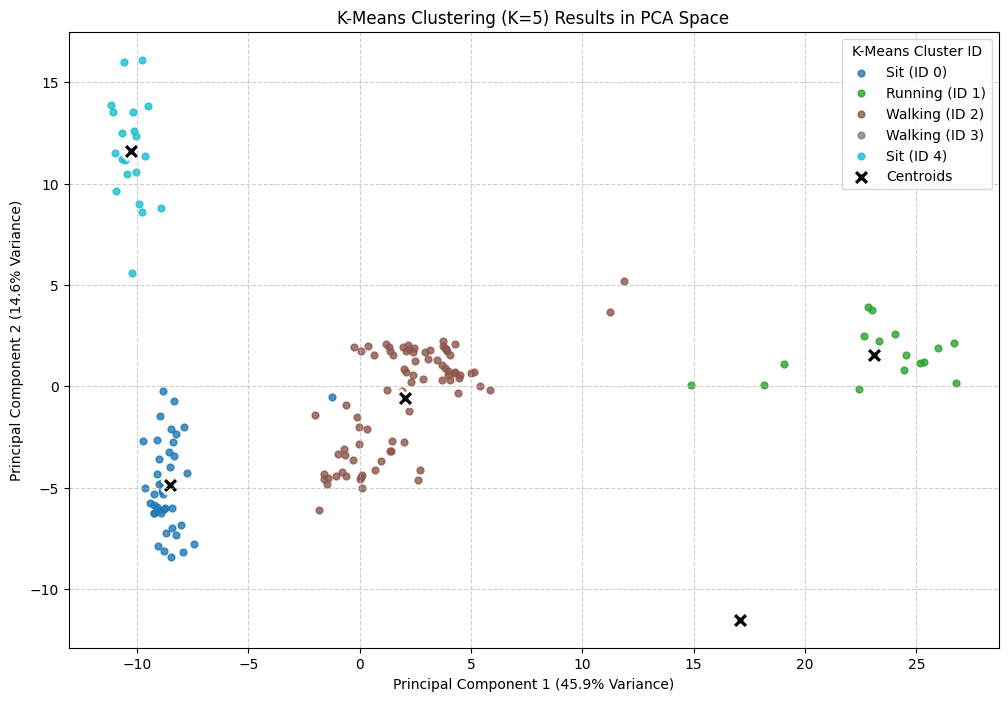

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load the data feature matrix and labels ## LATER ON WE CAN REMOVE THE PROMPT AND JUST LOAD THE CSV
try:
    df = pd.read_csv("features.csv")
except FileNotFoundError:
    print("Error: features.csv not found. Please ensure the file is in the current directory.")
    exit()

# Identify Non-Feature columns
Non_feat_columns = ['activity', 'trial', 'student', 'window_idx']

#Drop the non-feature columns so that we only have the features left
X = df.drop(columns=Non_feat_columns, errors='ignore')

# We use the activity column for evaluation later (since, during recordings we have labeled each entry with an activity).We don't use it for clustering since K-Means is unsupervised.
y_true = df['activity'].astype('category')
Nr_clusters = y_true.nunique() # Counts the number of unique activities and assigns it to Nr_clusters

print(f"Total samples (windows): {X.shape[0]}")
print(f"Total features used: {X.shape[1]}")
print(f"Number of clusters (K): {Nr_clusters}")
print("-" * 40)

#Use StandardScaler from sklearn to standardize the features. It centers the data (mean=0) and scales it (std=1).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Since we are going to visualize the clusters in 2D, we use PCA to reduce the dimensionality of the feature space to 2 principal components (PC1, PC2)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Variance Explained by PC1: {explained_variance[0]:.2f}")
print(f"Variance Explained by PC2: {explained_variance[1]:.2f}")
print(f"Total Variance Explained: {sum(explained_variance):.2f}")
print("-" * 40)

#Create and train the K-Means model
K_means_model = KMeans(
    n_clusters=Nr_clusters,
    init='k-means++', # Smart initialization method
    max_iter=300,
    n_init=10, # Run 10 times with different centroids to find the best result
    random_state=33
)
K_means_model.fit(X_scaled)
cluster_labels = K_means_model.labels_ # Get the cluster assignments (labels)

# Here we assign labels to the cluster IDs based on the majority class within that cluster.
# It helps with interpreting what each cluster represents.
df_labeled_temp = pd.DataFrame({
    'Cluster_ID': cluster_labels,
    'True_Activity': y_true
})

# Create the Contingency Table (Cross-Tabulation)
contingency_table = pd.crosstab(
    df_labeled_temp['Cluster_ID'],
    df_labeled_temp['True_Activity']
)

# Determine the majority activity for each cluster ID
cluster_to_activity_mapping = {}
for cluster_id in contingency_table.index:
    majority_activity = contingency_table.loc[cluster_id].idxmax()
    cluster_to_activity_mapping[cluster_id] = majority_activity

unique_clusters = np.unique(cluster_labels) # Get the unique cluster IDs


#Plotting and Visualization

plt.figure(figsize=(12, 8))
cmap = plt.cm.get_cmap('tab10', len(unique_clusters))

# Iterate through each cluster ID to plot it separately, which allows for a clean legend
for cluster_id in unique_clusters:
    indices = cluster_labels == cluster_id
    activity_name = cluster_to_activity_mapping[cluster_id]

    # Plot the subset of points for this cluster
    plt.scatter(
        X_pca[indices, 0],              # PC1 on the X-axis
        X_pca[indices, 1],              # PC2 on the Y-axis
        c=[cmap(cluster_id)],           # Assign the color from the colormap
        label=f'{activity_name} (ID {cluster_id})',  # Use the Activity Name + ID
        alpha=0.8,
        s=24,
    )

# Centroids must also be transformed to the PCA space for plotting
centroids = K_means_model.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=150,
    linewidths=2,
    color='black',
    edgecolors='white',
    label='Centroids'
)


# Set labels, title, and legend
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.1f}% Variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.1f}% Variance)")
plt.title(f"K-Means Clustering (K={Nr_clusters}) Results in PCA Space")
plt.legend(title='K-Means Cluster ID', loc='best')
plt.grid(True, linestyle='--', alpha=0.6)


#Evaluation of the model using the true labels for reference

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(y_true, cluster_labels)
nmi = normalized_mutual_info_score(y_true, cluster_labels)


print(f"Adjusted Rand Index (ARI): {ari:.4f} (0.0=random, 1.0=perfect match)")
print(f"Normalized Mutual Information (NMI): {nmi:.4f} (0.0=no mutual info, 1.0=perfect match)")

### Fuzzy C-means
